In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import gc
import time

from utils import *

PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/test_supplement.csv'),
 PosixPath('data/train_10mil.feather'),
 PosixPath('data/val_df_1mil_fe_v1.feather'),
 PosixPath('data/test.feather'),
 PosixPath('data/train_df_1mil_fe_v1.feather'),
 PosixPath('data/train_df_10mil_fe_v1.feather'),
 PosixPath('data/train.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train_50mil.feather'),
 PosixPath('data/train_sample.csv'),
 PosixPath('data/val_df_10mil_fe_v1.feather'),
 PosixPath('data/train_1mil.feather'),
 PosixPath('data/test.csv'),
 PosixPath('data/train_10mil_fe.feather')]

In [8]:
def metric(rf,X_val,y_val):
    y_val_pred = rf.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val,y_val_pred)

def permutation_importances(rf,X_val,y_val,metric):
    baseline = metric(rf,X_val,y_val)
    imp=[]
    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])
        m = metric(rf,X_val,y_val)
        print(f'Score after {col} perm: {m:.5f}')
        X_val[col] = save
        imp.append(baseline-m)
    return np.array(imp)

# Get data

In [2]:
train_df=get_feather('train_df_10mil_fe_v1.feather')
val_df=get_feather('val_df_10mil_fe_v1.feather')

In [3]:
y_train = train_df.is_attributed
train_df.drop('is_attributed',axis=1,inplace=True)

y_val = val_df.is_attributed
val_df.drop('is_attributed',axis=1,inplace=True)
gc.collect()

14

In [24]:
train_df.hour.value_counts()

13    3457523
14    3443283
15    1026558
12      72636
Name: hour, dtype: int64

In [25]:
val_df.hour.value_counts()

15    1999553
16        447
Name: hour, dtype: int64

In [4]:
# train_df.isnull().sum()
# val_df.isnull().sum()

train_df.fillna(0,inplace=True)

# RF

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=30,max_features=.8,oob_score=False,
                           min_samples_leaf=10,n_jobs=-1,class_weight={1:100})

In [15]:
%%time
rf.fit(train_df,y_train)


CPU times: user 1h 46min 22s, sys: 30.6 s, total: 1h 46min 53s
Wall time: 28min 49s


RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=None, max_features=0.8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [16]:
y_train_pred = rf.predict_proba(train_df)[:,1]
roc_auc_score(y_train, y_train_pred)
y_val_pred = rf.predict_proba(val_df)[:,1]
roc_auc_score(y_val, y_val_pred)

0.9998211812876828

0.8079079103879495

In [13]:
train_df.hour.value_counts()
val_df.hour.value_counts()

13    3457523
14    3443283
15    1026558
12      72636
Name: hour, dtype: int64

15    1999553
16        447
Name: hour, dtype: int64

Score after ip perm: 0.80654
Score after app perm: 0.81367
Score after device perm: 0.80719
Score after os perm: 0.80792
Score after channel perm: 0.80893
Score after ip_next_click perm: 0.80752
Score after ip_app_next_click perm: 0.80507
Score after ip_channel_next_click perm: 0.80803
Score after ip_os_next_click perm: 0.80801
Score after day perm: 0.80791
Score after hour perm: 0.80791
Score after minute perm: 0.80842
Score after second perm: 0.80794
Score after ip_device_os_cumcount perm: 0.80367
Score after ip_device_os_app_cumcount perm: 0.82232
Score after ip_mean_target perm: 0.57840
Score after app_mean_target perm: 0.80829
Score after device_mean_target perm: 0.80795
Score after channel_mean_target perm: 0.80627
Score after app_channel_mean_target perm: 0.73717
Score after app_os_mean_target perm: 0.79657
Score after app_device_mean_target perm: 0.80156
Score after ip_app_channel_var_day perm: 0.80791
Score after ip_app_os_var_hour perm: 0.80770
Score after ip_day_channel_var_

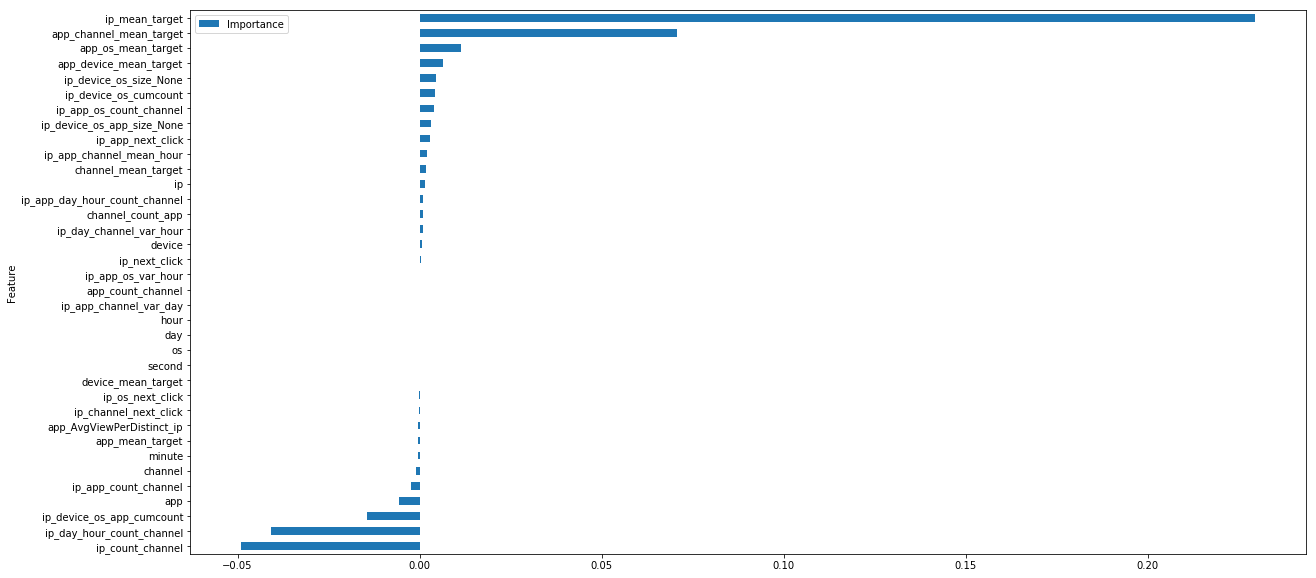

In [17]:
fea_imp = permutation_importances(rf,val_df,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':val_df.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))

# RF hyperparam tuning

In [18]:
rf = RandomForestClassifier(n_estimators=25,max_features=.8,oob_score=False,
                           min_samples_leaf=10,n_jobs=-1,class_weight={1:200})
rf.fit(train_df,y_train)


y_train_pred = rf.predict_proba(train_df)[:,1]
print(roc_auc_score(y_train, y_train_pred))
y_val_pred = rf.predict_proba(val_df)[:,1]
print(roc_auc_score(y_val, y_val_pred))

RandomForestClassifier(bootstrap=True, class_weight={1: 200},
            criterion='gini', max_depth=None, max_features=0.8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.99981887488044
0.8022400240460176


In [19]:
rf = RandomForestClassifier(n_estimators=40,max_features=.7,oob_score=False,
                           min_samples_leaf=20,n_jobs=-1,class_weight={1:100})
rf.fit(train_df,y_train)


y_train_pred = rf.predict_proba(train_df)[:,1]
print(roc_auc_score(y_train, y_train_pred))
y_val_pred = rf.predict_proba(val_df)[:,1]
print(roc_auc_score(y_val, y_val_pred))

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=None, max_features=0.7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.9996364013954929
0.8250244905001265


In [21]:
rf = RandomForestClassifier(n_estimators=20,max_features=.7,oob_score=False,
                            max_depth=10,
                           min_samples_leaf=15,n_jobs=-1,class_weight={1:100})
rf.fit(train_df,y_train)


y_train_pred = rf.predict_proba(train_df)[:,1]
print(roc_auc_score(y_train, y_train_pred))
y_val_pred = rf.predict_proba(val_df)[:,1]
print(roc_auc_score(y_val, y_val_pred))

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=10, max_features=0.7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.9963536656812625
0.7500110378627445


In [23]:
rf = RandomForestClassifier(n_estimators=20,max_features=.7,oob_score=False,
                            max_depth=20,
                           min_samples_leaf=10,n_jobs=-1,class_weight={1:100})
rf.fit(train_df,y_train)


y_train_pred = rf.predict_proba(train_df)[:,1]
print(roc_auc_score(y_train, y_train_pred))
y_val_pred = rf.predict_proba(val_df)[:,1]
print(roc_auc_score(y_val, y_val_pred))

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=20, max_features=0.7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.9994709847726029
0.7944541941977767


Score after ip perm: 0.80280
Score after app perm: 0.80221
Score after device perm: 0.80253
Score after os perm: 0.80290
Score after channel perm: 0.80269
Score after ip_next_click perm: 0.80248
Score after ip_app_next_click perm: 0.80041
Score after ip_channel_next_click perm: 0.80211
Score after ip_os_next_click perm: 0.80242
Score after day perm: 0.80257
Score after hour perm: 0.80257
Score after minute perm: 0.80307
Score after second perm: 0.80372
Score after ip_device_os_cumcount perm: 0.80305
Score after ip_device_os_app_cumcount perm: 0.80330
Score after ip_mean_target perm: 0.60214
Score after app_mean_target perm: 0.80279
Score after device_mean_target perm: 0.80236
Score after channel_mean_target perm: 0.80360
Score after app_channel_mean_target perm: 0.54776
Score after app_os_mean_target perm: 0.78467
Score after app_device_mean_target perm: 0.79713
Score after ip_app_channel_var_day perm: 0.80257
Score after ip_app_os_var_hour perm: 0.80198
Score after ip_day_channel_var_

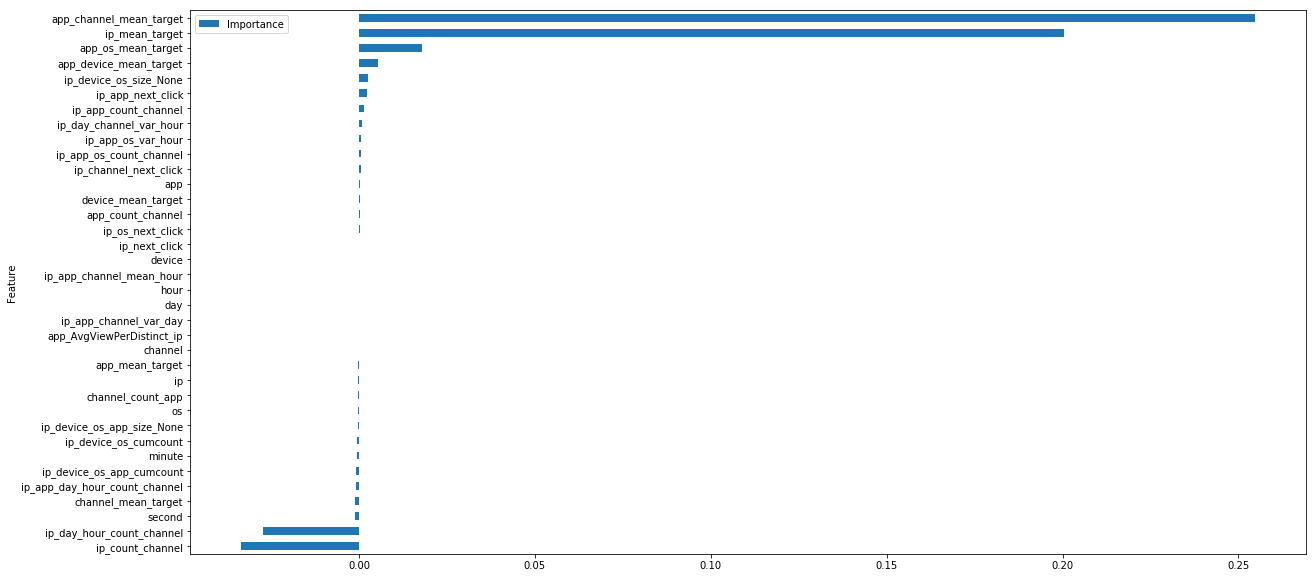

# -----------------------------------

# RF

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [96]:
rf = RandomForestClassifier(n_estimators=20,max_features=.6,oob_score=False,
                           min_samples_leaf=5,n_jobs=-1,class_weight={1:100})

In [97]:
%%time
rf.fit(train_df,y_train)

CPU times: user 2min 4s, sys: 4.58 s, total: 2min 8s
Wall time: 34.6 s


RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=None, max_features=0.6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [98]:
# n=20, mf=.6, msl=5, cw 100
y_train_pred = rf.predict_proba(train_df)[:,1]
roc_auc_score(y_train, y_train_pred)
y_val_pred = rf.predict_proba(val_df)[:,1]
roc_auc_score(y_val, y_val_pred)

0.999980685782753

0.9057156468676283

In [91]:
# # n=20, mf=.8, msl=5, cw 100
# y_train_pred = rf.predict_proba(train_df)[:,1]
# roc_auc_score(y_train, y_train_pred)
# y_val_pred = rf.predict_proba(val_df)[:,1]
# roc_auc_score(y_val, y_val_pred)

0.9999818741643153

0.9175385035748761

# Feature Importance

In [94]:
fea_imp = permutation_importances(rf,val_df,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':val_df.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)

Score after ip perm: 0.91754
Score after app perm: 0.91753
Score after device perm: 0.91502
Score after os perm: 0.91755
Score after channel perm: 0.91749
Score after ip_next_click perm: 0.91734
Score after ip_app_next_click perm: 0.91752
Score after ip_channel_next_click perm: 0.91765
Score after ip_os_next_click perm: 0.91756
Score after day perm: 0.91754
Score after hour perm: 0.91754
Score after minute perm: 0.91754
Score after second perm: 0.91753
Score after ip_device_os_cumcount perm: 0.91736
Score after ip_device_os_app_cumcount perm: 0.93246
Score after ip_mean_target perm: 0.54363
Score after app_mean_target perm: 0.91754
Score after device_mean_target perm: 0.91757
Score after channel_mean_target perm: 0.91252
Score after app_channel_mean_target perm: 0.82022
Score after app_os_mean_target perm: 0.60892
Score after app_device_mean_target perm: 0.91499
Score after ip_app_channel_var_day perm: 0.91754
Score after ip_app_os_var_hour perm: 0.91754
Score after ip_day_channel_var_

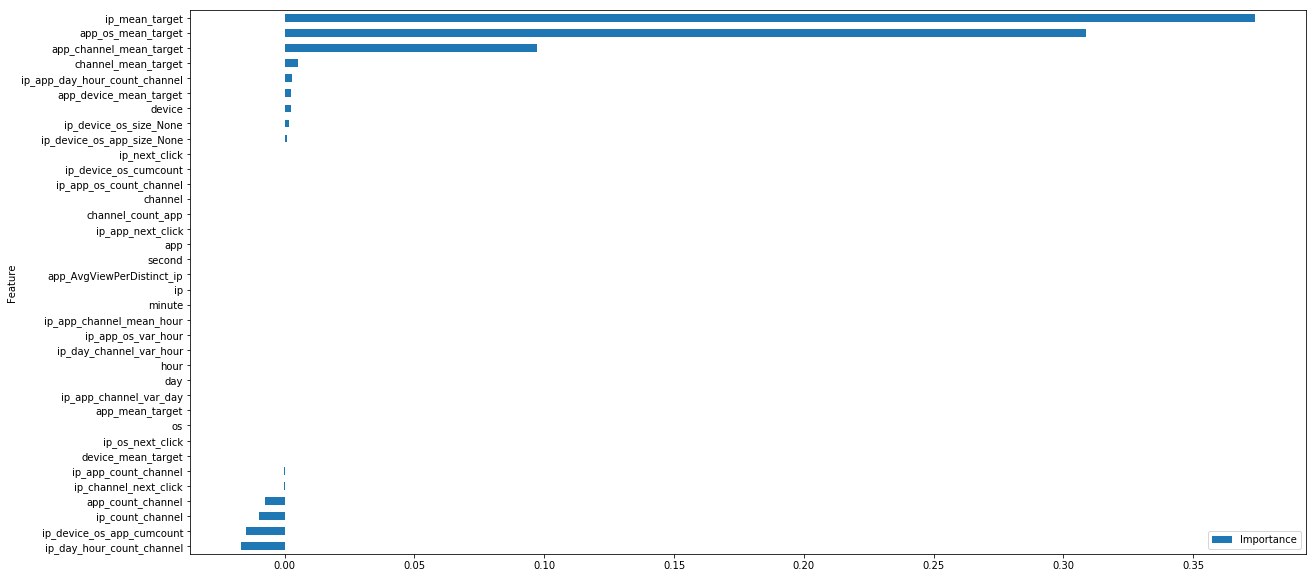

In [95]:
fea_imp_df.plot(kind='barh',figsize=(20,10))